In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Concatenate, Average
from tensorflow.keras.models import model_from_json
from tensorflow.keras import callbacks

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import lightgbm as lgb

In [2]:
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('/content/drive/My Drive/MLHC/project_1')

In [0]:
from CNN_arch import CNN
from RNN_arch import RNN
from CRNN_arch import CRNN
from CNNR_arch import CNNR

## Load & inspect datasets

### MIT Dataset

In [0]:
df_train = pd.read_csv("data/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("data/mitbih_test.csv", header=None)

Y_mit = np.array(df_train[187].values).astype(np.int8)
X_mit = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test_mit = np.array(df_test[187].values).astype(np.int8)
X_test_mit = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [0]:
print(len(Y_mit), "training samples and", len(Y_test_mit), "testing samples of shape", X_mit[0].shape)

87554 training samples and 21892 testing samples of shape (187, 1)


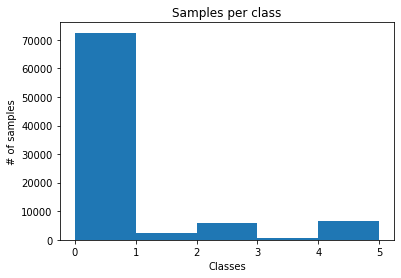

In [0]:
plt.hist(Y_mit, bins=range(len(np.bincount(Y_mit))+1))
plt.title("Samples per class")
plt.xlabel("Classes")
plt.ylabel("# of samples")
plt.show()

### PTB Dataset

In [0]:
df_1 = pd.read_csv("data/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("data/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

Y_ptb = np.array(df_train[187].values).astype(np.int8)
X_ptb = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test_ptb = np.array(df_test[187].values).astype(np.int8)
X_test_ptb = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [0]:
print(len(Y_ptb), "training samples and", len(Y_test_ptb), "testing samples of shape", X_ptb[0].shape)

11641 training samples and 2911 testing samples of shape (187, 1)


In [0]:
bc = np.bincount(Y_ptb)
print(bc[0], "samples in class 0 and", bc[1], "samples in class 1")

3237 samples in class 0 and 8404 samples in class 1


## Setup

### Wrapper Class
This class will help us train, evaluate and compare our models

In [0]:
class Model_Wrapper:
    def __init__(self, model_class):
        self.model_class = model_class
        self.model = model_class.model
        self.name = model_class.name
        self.dir = './models/'+model_class.name+'/'
        if not os.path.exists(self.dir):
            os.makedirs(self.dir)
  
    def set_weights(self):
        self.model.load_weights(self.dir+self.name+'_weights.h5')

    def save_weights(self):
        self.model.save_weights(self.dir+self.name+'_weights.h5')

    def set_model(self):
        # load json and create model
        json_file = open(self.dir+self.name+"_model.json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = model_from_json(loaded_model_json)
        self.set_weights()
        print("Loaded", self.name, "from disk")

    def save_model(self):
        model_json = self.model.to_json()
        with open(self.dir+self.name+"_model.json", "w") as json_file:
            json_file.write(model_json)
        self.save_weights()
        print("Saved", self.name, "to disk")

    def train(self, X, Y, shuffle=True, epochs=100, batch_size=None, save=True, verbose=1, validation_split=.1):
        cbs = []
        cbs.append(EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1))
        cbs.append(ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2))
        if save:
            cbs.append(callbacks.TensorBoard(log_dir=self.dir+'log/'))
            cbs.append(ModelCheckpoint(self.dir+self.name+'_weights.h5', monitor='val_acc', verbose=verbose, save_best_only=True, mode='max'))
        self.model.fit(X, Y,
                shuffle=shuffle,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=cbs,
                verbose=verbose,
                validation_split=validation_split)

### Helper functions

Takes a model wrapper (class defined above) and evaluates its performance on the provided test set, outputs the accuracy, f1 score, confusion matrix and summary of the model (also AUROC and AUPRC for binary classifiers) and saves the results in a txt file if required.

In [0]:
def evaluate_model(model_wrapper, X_test, Y_test, save=True):
    pred_test = model_wrapper.model.predict(X_test)
    if pred_test.shape[1] > 1:
        pred_test = np.argmax(pred_test, axis=1)
    else:
        pred_test = np.round(pred_test).reshape(-1).astype(int)
    
    f1 = f1_score(Y_test, pred_test, average="macro")
    acc = accuracy_score(Y_test, pred_test)

    classes = np.bincount(pred_test).size
    if classes <= 2:auroc = roc_auc_score(Y_test, pred_test)
    if classes <= 2:auprc = average_precision_score(Y_test, pred_test)
    cm = confusion_matrix(Y_test, pred_test)
    
    print("\n=================================================================")
    print("\nAccuracy:", round(acc, 5))
    print("F1:      ", round(f1, 5))
    if classes <= 2:print("AUROC    ", round(auroc, 5))
    if classes <= 2:print("AUPRC    ", round(auprc, 5))
    print("Confusion matrix:")
    print(cm)
    print("Accuracy per class")
    print(cm.diagonal() / np.sum(cm, axis=1))
    print("\n=================================================================\n")
    
    if save:
        with open(model_wrapper.dir + 'report.txt','w') as fh:
            fh.write("Accuracy:      "+str(acc)+"\n")
            fh.write("F1:            "+str(f1)+"\n")
            fh.write("Confusion mat:\n "+str(cm)+"\n")
            fh.write("Acc per class: "+str(cm.diagonal() / np.sum(cm, axis=1))+"\n")
            if classes <= 2:fh.write("AUROC:    "+str(auroc)+"\n")
            if classes <= 2:fh.write("AUPRC:    "+str(auprc)+"\n\n")
            if type(model_wrapper.model.summary) is not str: model_wrapper.model.summary(print_fn=lambda x: fh.write(x + '\n'))
    return (f1, acc)

Runs K-Fold cross-validation and pretty-prints intermediate results.

In [0]:
def cross_validation(model_wrapper, X, Y, folds=5, shuffle=True, epochs=100, batch_size=None, verbose=0, validation_split=.1):
    kf = KFold(n_splits=folds)
    i = 0.
    f1_a = 0
    acc_a = 0
    for train_index, test_index in kf.split(X):
        print("Iteration", int(i+1))
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model_wrapper.model_class.model = model_wrapper.model_class.get_model()
        model_wrapper.model_class.compile_model()
        cv_model = Model_Wrapper(model_wrapper.model_class)
        cv_model.train(X_train, Y_train, epochs=epochs, batch_size=batch_size, save=False, verbose=verbose, shuffle=shuffle, validation_split=validation_split)
        f1, acc = evaluate_model(X_test, Y_test, save=False)
        f1_a += f1
        acc_a += acc
        i += 1
    print("\n=================================================================")
    print("\nAverage Accuracy:", round(acc_a/i, 5))
    print("Average F1:      ", round(f1_a/i, 5))
    print("\n=================================================================\n")

## Baseline

### MIT Dataset

In [0]:
# Change 'Baseline_MIT' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
cnn_mit_wrapper = Model_Wrapper(CNN('Baseline_MIT_test', 'sparse_categorical_crossentropy', 5))
cnn_mit_wrapper.model.summary()

In [0]:
cnn_mit_wrapper.train(X_mit, Y_mit)
cnn_mit_wrapper.set_weights()
cnn_mit_wrapper.save_model()

Train on 78798 samples, validate on 8756 samples
Epoch 1/100
74432/78798 [===========================>..] - ETA: 1s - loss: 0.3397 - acc: 0.9035

KeyboardInterrupt: ignored

In [0]:
cnn_mit_wrapper.set_model()
evaluate_model(cnn_mit_wrapper, X_test_mit, Y_test_mit)

Loaded model from disk


Accuracy: 0.98474
F1:       0.90941
Confusion matrix:
[[18049    30    27     8     4]
 [  114   430    11     0     1]
 [   49     5  1370    19     5]
 [   25     1    18   118     0]
 [   15     0     2     0  1591]]
Accuracy per class
[0.99619163 0.77338129 0.9461326  0.72839506 0.98942786]




(0.9094072988722587, 0.9847432852183446)

### PTB Dataset

In [0]:
# Change 'Baseline_PTB' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
cnn_ptb_wrapper = Model_Wrapper(CNN('Baseline_PTB', 'binary_crossentropy', 1, last_activation='sigmoid'))
cnn_ptb_wrapper.model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "Baseline_PTB"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 183, 16)           96        
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 89, 16)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 89, 16)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 87, 32)            1568      
__________________________

In [0]:
cnn_ptb_wrapper.train(X_ptb, Y_ptb)
cnn_ptb_wrapper.set_weights()
cnn_ptb_wrapper.save_model()

In [0]:
cnn_ptb_wrapper.set_model()
evaluate_model(cnn_ptb_wrapper, X_test_ptb, Y_test_ptb)

Loaded model from disk


Accuracy: 0.98969
F1:       0.98715
AUROC     0.98678
AUPRC     0.9906
Confusion matrix:
[[ 793   16]
 [  14 2088]]




(0.9871514879733337, 0.9896942631398145)

## Our Models

### LSTM

#### MIT Dataset

In [7]:
# Change 'RNN_MIT' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
lstm_mit_wrapper = Model_Wrapper(RNN('RNN_MIT_Bidirectional', lstm_size=150))
lstm_mit_wrapper.model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "RNN_MIT_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               183600    
_________________________________________________________________
dense (Dense)                (None, 200)               60200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_____________________

In [0]:
lstm_mit_wrapper.train(X_mit, Y_mit, batch_size=100)
lstm_mit_wrapper.set_weights()
lstm_mit_wrapper.save_model()

In [0]:
lstm_mit_wrapper.set_model()
evaluate_model(lstm_mit_wrapper, X_test_mit, Y_test_mit)

Loaded model from disk


Accuracy: 0.98374
F1:       0.91198
Confusion matrix:
[[18059    24    21     5     9]
 [  139   410     6     0     1]
 [   58     1  1367    18     4]
 [   25     1    12   124     0]
 [   23     3     6     0  1576]]
Accuracy per class
[0.99674357 0.73741007 0.94406077 0.7654321  0.9800995 ]




(0.9119846124056158, 0.9837383519093733)

#### PTB Dataset

In [0]:
# Change 'RNN_PTB' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
lstm_ptb_wrapper = Model_Wrapper(RNN('RNN_PTB_Bidirectional', output_dim=1, loss='binary_crossentropy', last_activation='sigmoid', lstm_size=150))
lstm_ptb_wrapper.model.summary()

Model: "RNN_PTB_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 187, 1)]          0         
_________________________________________________________________
bidirectional_62 (Bidirectio (None, 300)               183600    
_________________________________________________________________
dense_22 (Dense)             (None, 200)               60200     
_________________________________________________________________
dropout_101 (Dropout)        (None, 200)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 201       
Total params: 244,001
Trainable params: 244,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm_ptb_wrapper.train(X_ptb, Y_ptb, validation_split=.2)
lstm_ptb_wrapper.set_weights()
lstm_ptb_wrapper.save_model()

In [0]:
lstm_ptb_wrapper.set_model()
evaluate_model(lstm_ptb_wrapper, X_test_ptb, Y_test_ptb)

Loaded model from disk


Accuracy: 0.96977
F1:       0.96231
AUROC     0.96196
AUPRC     0.97336
Confusion matrix:
[[ 764   45]
 [  43 2059]]
Accuracy per class
[0.94437577 0.97954329]




(0.9623110313884454, 0.9697698385434559)

### Convolutional RNN

#### MIT Dataset

In [9]:
# Change 'Conv_RNN_MIT' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
convrnn_mit_wrapper = Model_Wrapper(CRNN('Conv_RNN_MIT_Bidirectional', X_mit.shape[1:], 5))
convrnn_mit_wrapper.model.summary()

NameError: ignored

In [0]:
convrnn_mit_wrapper.train(X_mit, Y_mit)
convrnn_mit_wrapper.set_weights()
convrnn_mit_wrapper.save_model()

In [0]:
convrnn_mit_wrapper.set_model()
evaluate_model(convrnn_mit_wrapper, X_test_mit, Y_test_mit)

Loaded model from disk


Accuracy: 0.98776
F1:       0.92468
Confusion matrix:
[[18057    34    13    11     3]
 [  100   446     8     1     1]
 [   29     6  1392    17     4]
 [   19     0    13   130     0]
 [    9     0     0     0  1599]]
Accuracy per class
[0.99663318 0.80215827 0.96132597 0.80246914 0.99440299]




(0.9246823476989399, 0.9877580851452585)

#### PTB Dataset

In [0]:
# Change 'Conv_RNN_PTB' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
convrnn_ptb_wrapper = Model_Wrapper(ConvRNN('Conv_RNN_PTB_Bidirectional', X_mit.shape[1:], 1, loss='binary_crossentropy', last_activation='sigmoid'))
convrnn_ptb_wrapper.model.summary()

Model: "Conv_RNN_PTB_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_186 (Conv1D)          (None, 185, 16)           64        
_________________________________________________________________
conv1d_187 (Conv1D)          (None, 183, 16)           784       
_________________________________________________________________
max_pooling1d_78 (MaxPooling (None, 91, 16)            0         
_________________________________________________________________
dropout_104 (Dropout)        (None, 91, 16)            0         
_________________________________________________________________
conv1d_188 (Conv1D)          (None, 89, 32)            1568      
_________________________________________________________________
conv1d_189 (Conv1D)          (None, 87, 

In [0]:
convrnn_ptb_wrapper.train(X_ptb, Y_ptb, validation_split=.2)
convrnn_ptb_wrapper.set_weights()
convrnn_ptb_wrapper.save_model()

In [0]:
convrnn_ptb_wrapper.set_model()
evaluate_model(convrnn_ptb_wrapper, X_test_ptb, Y_test_ptb)

Loaded model from disk


Accuracy: 0.98695
F1:       0.98368
AUROC     0.98184
AUPRC     0.98686
Confusion matrix:
[[ 785   24]
 [  14 2088]]
Accuracy per class
[0.97033375 0.99333968]




(0.9836752993457015, 0.986946066643765)

### CNN with Residuals

#### MIT Dataset

In [10]:
# Change 'CNN_RES_MIT' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
cnn_res_mit_wrapper = Model_Wrapper(CNNR('CNN_RES_MIT', X_mit.shape[1:], 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_res_mit_wrapper.model.summary()

NameError: ignored

In [0]:
cnn_res_mit_wrapper.train(X_mit, Y_mit)
cnn_res_mit_wrapper.set_weights()
cnn_res_mit_wrapper.save_model()

In [0]:
cnn_res_mit_wrapper.set_model()
evaluate_model(cnn_res_mit_wrapper, X_test_mit, Y_test_mit)

Loaded model from disk


Accuracy: 0.98506
F1:       0.9146
Confusion matrix:
[[18066    23    18     8     3]
 [  154   391    10     1     0]
 [   42     1  1387    15     3]
 [   13     0    19   130     0]
 [   15     0     1     1  1591]]
Accuracy per class
[0.99712993 0.70323741 0.95787293 0.80246914 0.98942786]




(0.9145959401334487, 0.9850630367257446)

#### PTB Dataset

In [0]:
# Change 'CNN_RES_PTB' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
cnn_res_ptb_wrapper = Model_Wrapper(CNNRes('CNN_RES_PTB', X_ptb.shape[1:], 1, 'binary_crossentropy', 'sigmoid'))
cnn_res_ptb_wrapper.model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_48 (Conv1D)              (None, 183, 32)      192         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 183, 32)      128         conv1d_48[0][0]                  
__________________________________________________________________________________________________
re_lu_8 (ReLU)                  (None, 183, 32)      0           batch_normalization_12[0][0]     
____________________________________________________________________________________________

In [0]:
cnn_res_ptb_wrapper.train(X_ptb, Y_ptb, validation_split=.2)
cnn_res_ptb_wrapper.set_weights()
cnn_res_ptb_wrapper.save_model()

In [0]:
cnn_res_ptb_wrapper.set_model()
evaluate_model(cnn_res_ptb_wrapper, X_test_ptb, Y_test_ptb)

Loaded model from disk


Accuracy: 0.9921
F1:       0.99015
AUROC     0.98959
AUPRC     0.99253
Confusion matrix:
[[ 796   13]
 [  10 2092]]




(0.9901457176267477, 0.9920989350738578)

## Transfer Learning

### Baseline

In [11]:
# Pretrained model to get the weights from. Change 'Baseline_MIT' to the name of your pretrained model.
cnn_mit_wrapper = Model_Wrapper(CNN('Baseline_MIT', 'sparse_categorical_crossentropy', 5))
cnn_mit_wrapper.set_model()

# Change 'Baseline_Transfer_Retrain' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
cnn_transfer = Model_Wrapper(CNN('Baseline_Transfer_Retrain', 'binary_crossentropy', 1, last_activation='sigmoid'))

Loaded Baseline_MIT from disk
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Copy all weights from the pretrained model, except for the last 3 dense layers
# If you want to freeze the pretrained layers, set trainable to False below
for i in range(17):
    cnn_transfer.model.layers[i].set_weights(cnn_mit_wrapper.model.layers[i].get_weights())
    cnn_transfer.model.layers[i].trainable = True   # set this to False if you want to reproduce the 'Freeze' results
cnn_transfer.model_class.compile_model()

In [0]:
# Check number of untrainable parameters, important if you set trainable layers to False above
cnn_transfer.model.summary()

Model: "Baseline_Transfer_Retrain"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_480 (Conv1D)          (None, 183, 16)           96        
_________________________________________________________________
conv1d_481 (Conv1D)          (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d_96 (MaxPooling (None, 89, 16)            0         
_________________________________________________________________
dropout_124 (Dropout)        (None, 89, 16)            0         
_________________________________________________________________
conv1d_482 (Conv1D)          (None, 87, 32)            1568      
_________________________________________________________________
conv1d_483 (Conv1D)          (None, 85, 3

In [0]:
# Train and save model
cnn_transfer.train(X_ptb, Y_ptb)
cnn_transfer.set_weights()
cnn_transfer.save_model()

In [0]:
# Evaluate model
cnn_transfer.set_model()
evaluate_model(cnn_transfer, X_test_ptb, Y_test_ptb)

Loaded model from disk


Accuracy: 0.95809
F1:       0.94787
AUROC     0.94855
AUPRC     0.96439
Confusion matrix:
[[ 750   59]
 [  63 2039]]
Accuracy per class
[0.92707046 0.97002854]




(0.9478682989842053, 0.9580900034352456)

### LSTM

In [12]:
# Pretrained model to get the weights from. Change 'RNN_MIT' to the name of your pretrained model.
lstm_mit_wrapper = Model_Wrapper(RNN('RNN_MIT_Bidirectional'))
lstm_mit_wrapper.set_model()

# Change 'RNN_Transfer_Retrain' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
lstm_transfer = Model_Wrapper(RNN('RNN_Transfer_Retrain_Bidirectional', output_dim=1, loss='binary_crossentropy', last_activation='sigmoid', lstm_size=100))

Loaded RNN_MIT_Bidirectional from disk


In [0]:
# Copy all weights from the pretrained model, except for the last 2 dense layers
# If you want to freeze the pretrained layers, set trainable to False below
for i in range(2):
    lstm_transfer.model.layers[i].set_weights(lstm_mit_wrapper.model.layers[i].get_weights())
    lstm_transfer.model.layers[i].trainable = True  # set this to False if you want to reproduce the 'Freeze' results
lstm_transfer.model_class.compile_model()

In [0]:
# Check number of untrainable parameters, important if you set trainable layers to False above
lstm_transfer.model.summary()

Model: "RNN_Transfer_Retrain_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_84 (InputLayer)        [(None, 187, 1)]          0         
_________________________________________________________________
bidirectional_72 (Bidirectio (None, 200)               82400     
_________________________________________________________________
dense_28 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_115 (Dropout)        (None, 200)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 201       
Total params: 122,801
Trainable params: 122,801
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Train and save model
lstm_transfer.train(X_ptb, Y_ptb, validation_split=.2)
lstm_transfer.set_weights()
lstm_transfer.save_model()

In [0]:
# Evaluate model
lstm_transfer.set_model()
evaluate_model(lstm_transfer, X_test_ptb, Y_test_ptb)

Loaded model from disk


Accuracy: 0.98798
F1:       0.98506
AUROC     0.98635
AUPRC     0.99061
Confusion matrix:
[[ 795   14]
 [  21 2081]]
Accuracy per class
[0.98269468 0.99000951]




(0.9850611242462564, 0.9879766403297836)

### CRNN

In [14]:
# Pretrained model to get the weights from. Change 'Conv_RNN_MIT' to the name of your pretrained model.
convrnn_mit_wrapper = Model_Wrapper(CRNN('Conv_RNN_MIT_Bidirectional', (187, 1), 1))
convrnn_mit_wrapper.set_model()

# Change 'Conv_RNN_Transfer_Retrain' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
convrnn_transfer = Model_Wrapper(CRNN('Conv_RNN_Transfer_Freeze_Bidirectional', (187, 1), 1, loss='binary_crossentropy', last_activation='sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Loaded Conv_RNN_MIT_Bidirectional from disk


In [0]:
# Copy all weights from the pretrained model, except for the last 2 dense layers
# If you want to freeze the pretrained layers, set trainable to False below
for i in range(11):
    convrnn_transfer.model.layers[i].set_weights(convrnn_mit_wrapper.model.layers[i].get_weights())
    convrnn_transfer.model.layers[i].trainable = False   # set this to False if you want to reproduce the 'Freeze' results
convrnn_transfer.model_class.compile_model()

In [0]:
# Check number of untrainable parameters, important if you set trainable layers to False above
convrnn_transfer.model.summary()

Model: "Conv_RNN_Transfer_Freeze_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_86 (InputLayer)        [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_202 (Conv1D)          (None, 185, 16)           64        
_________________________________________________________________
conv1d_203 (Conv1D)          (None, 183, 16)           784       
_________________________________________________________________
max_pooling1d_86 (MaxPooling (None, 91, 16)            0         
_________________________________________________________________
dropout_118 (Dropout)        (None, 91, 16)            0         
_________________________________________________________________
conv1d_204 (Conv1D)          (None, 89, 32)            1568      
_________________________________________________________________
conv1d_205 (Conv1D)         

In [0]:
# Train and save model
convrnn_transfer.train(X_ptb, Y_ptb, validation_split=.2)
convrnn_transfer.set_weights()
convrnn_transfer.save_model()

In [0]:
# Evaluate model
convrnn_transfer.set_model()
evaluate_model(convrnn_transfer, X_test_ptb, Y_test_ptb)

Loaded model from disk


Accuracy: 0.98282
F1:       0.97862
AUROC     0.97898
AUPRC     0.98528
Confusion matrix:
[[ 785   24]
 [  26 2076]]
Accuracy per class
[0.97033375 0.98763083]




(0.9786183534002033, 0.9828237718996908)

### CNN with Residuals

In [15]:
# Pretrained model to get the weights from. Change 'Conv_RNN_MIT' to the name of your pretrained model.
cnn_res_ptb_wrapper = Model_Wrapper(CNNR('CNN_RES_MIT', (187, 1), 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_res_ptb_wrapper.set_model()

# Change 'CNN_RES_Transfer_Retrain' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
cnn_res_transfer = Model_Wrapper(CNNR('CNN_RES_Transfer_Retrain', (187, 1), 1, 'binary_crossentropy', 'sigmoid'))

NameError: ignored

In [0]:
# Copy all weights from the pretrained model, except for the last 3 dense layers
# If you want to freeze the pretrained layers, set trainable to False below
for i in range(36):
    cnn_res_transfer.model.layers[i].set_weights(cnn_res_ptb_wrapper.model.layers[i].get_weights())
    cnn_res_transfer.model.layers[i].trainable = True   # set this to False if you want to reproduce the 'Freeze' results
cnn_res_transfer.model_class.compile_model()

In [0]:
# Check number of untrainable parameters, important if you set trainable layers to False above
cnn_res_transfer.model.summary()

Model: "model_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_77 (InputLayer)           [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_508 (Conv1D)             (None, 183, 32)      192         input_77[0][0]                   
__________________________________________________________________________________________________
batch_normalization_221 (BatchN (None, 183, 32)      128         conv1d_508[0][0]                 
__________________________________________________________________________________________________
re_lu_176 (ReLU)                (None, 183, 32)      0           batch_normalization_221[0][0]    
___________________________________________________________________________________________

In [0]:
# Train and save model
cnn_res_transfer.train(X_ptb, Y_ptb, validation_split=.2)
cnn_res_transfer.set_weights()
cnn_res_transfer.save_model()

In [0]:
# Evaluate model
cnn_res_transfer.set_model()
evaluate_model(cnn_res_transfer, X_test_ptb, Y_test_ptb)

Loaded model from disk


Accuracy: 0.98935
F1:       0.98663
AUROC     0.98274
AUPRC     0.98712
Confusion matrix:
[[ 783   26]
 [   5 2097]]
Accuracy per class
[0.96786156 0.99762131]




(0.9866256627626504, 0.9893507385778083)

## Ensembling

### Averaging

In [0]:
class Averaging:
    def __init__(self, name, models: list):
        self.name = name
        self.models = models
        self.model = self.get_model()

    def get_model(self):
        X = Input(shape=(187,1))
        outputs = [model(X) for model in self.models]
        y = Average(name='average')(outputs)
        
        model = models.Model(X, y, name='average ensemble')
        
        return model

#### MIT Dataset

In [18]:
cnn_mit_avg_wrapper = Model_Wrapper(CNN('Baseline_MIT', 'sparse_categorical_crossentropy', 5))
cnn_mit_avg_wrapper.set_model()

lstm_mit_avg_wrapper = Model_Wrapper(RNN('RNN_MIT_Bidirectional'))
lstm_mit_avg_wrapper.set_model()

convrnn_mit_avg_wrapper = Model_Wrapper(CRNN('Conv_RNN_MIT_Bidirectional', (187, 1), 5))
convrnn_mit_avg_wrapper.set_model()

cnn_res_mit_avg_wrapper = Model_Wrapper(CNNR('CNN_RES_MIT', (187, 1), 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_res_mit_avg_wrapper.set_model()

Loaded Baseline_MIT from disk
Loaded RNN_MIT_Bidirectional from disk
Loaded Conv_RNN_MIT_Bidirectional from disk


NameError: ignored

In [0]:
# Change 'Ensemble_AVG_MIT' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
ensemble_avg_mit = Model_Wrapper(Averaging("Ensemble_AVG_MIT_Bidirectional", \
                                           [cnn_mit_avg_wrapper.model, convrnn_mit_avg_wrapper.model, cnn_res_mit_avg_wrapper.model, lstm_mit_avg_wrapper.model]))
ensemble_avg_mit.save_model()

In [0]:
evaluate_model(ensemble_avg_mit, X_test_mit, Y_test_mit)



Accuracy: 0.98831
F1:       0.9301
Confusion matrix:
[[18093    14     8     2     1]
 [  120   427     7     1     1]
 [   40     1  1390    16     1]
 [   17     0    15   130     0]
 [   12     0     0     0  1596]]
Accuracy per class
[0.99862016 0.76798561 0.95994475 0.80246914 0.99253731]




(0.9300968984318707, 0.9883062305865157)

#### PTB Dataset

In [19]:
cnn_ptb_avg_wrapper = Model_Wrapper(CNN('Baseline_PTB', 'binary_crossentropy', 1, last_activation='sigmoid'))
cnn_ptb_avg_wrapper.set_model()

lstm_ptb_avg_wrapper = Model_Wrapper(RNN('RNN_PTB_Bidirectional', (187, 1), 1, loss='binary_crossentropy', last_activation='sigmoid'))
lstm_ptb_avg_wrapper.set_model()

convrnn_ptb_avg_wrapper = Model_Wrapper(CRNN('Conv_RNN_PTB_Bidirectional', (187, 1), 1, loss='binary_crossentropy', last_activation='sigmoid'))
convrnn_ptb_avg_wrapper.set_model()

cnn_res_ptb_avg_wrapper = Model_Wrapper(CNNR('CNN_RES_PTB', (187, 1), 1, 'binary_crossentropy', 'sigmoid'))
cnn_res_ptb_avg_wrapper.set_model()

cnn_ptb_avg_transfer_wrapper = Model_Wrapper(CNN('Baseline_Transfer_Retrain', 'binary_crossentropy', 1, last_activation='sigmoid'))
cnn_ptb_avg_transfer_wrapper.set_model()

lstm_ptb_avg_transfer_wrapper = Model_Wrapper(RNN('RNN_Transfer_Retrain_Bidirectional', (187, 1), 1, loss='binary_crossentropy', last_activation='sigmoid'))
lstm_ptb_avg_transfer_wrapper.set_model()

convrnn_ptb_avg_transfer_wrapper = Model_Wrapper(CRNN('Conv_RNN_Transfer_Retrain_Bidirectional', X_mit.shape[1:], 1, loss='binary_crossentropy', last_activation='sigmoid'))
convrnn_ptb_avg_transfer_wrapper.set_model()

cnn_res_ptb_avg_transfer_wrapper = Model_Wrapper(CNNR('CNN_RES_Transfer_Retrain', X_mit.shape[1:], 1, 'binary_crossentropy', 'sigmoid'))
cnn_res_ptb_avg_transfer_wrapper.set_model()

Loaded Baseline_PTB from disk


NameError: ignored

In [0]:
# Change 'Ensemble_AVG_PTB' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
ensemble_avg_ptb = Model_Wrapper(Averaging("Ensemble_AVG_PTB_Bidirectional",\
                                           [cnn_ptb_avg_wrapper.model, \
                                            lstm_ptb_avg_wrapper.model, \
                                            convrnn_ptb_avg_wrapper.model, \
                                            cnn_res_ptb_avg_wrapper.model, \
                                            lstm_ptb_avg_transfer_wrapper.model, \
                                            cnn_ptb_avg_transfer_wrapper.model, \
                                            convrnn_ptb_avg_transfer_wrapper.model, \
                                            cnn_res_ptb_avg_transfer_wrapper.model]))
ensemble_avg_ptb.save_model()

Saved Ensemble_AVG_PTB_Bidirectional to disk


In [0]:
evaluate_model(ensemble_avg_ptb, X_test_ptb, Y_test_ptb)



Accuracy: 0.99656
F1:       0.99571
AUROC     0.99496
AUPRC     0.99628
Confusion matrix:
[[ 802    7]
 [   3 2099]]
Accuracy per class
[0.99134734 0.99857279]




(0.9957138936397775, 0.9965647543799382)

### Neural Layer Ensembling

In [0]:
class NNEnsemble:
    def __init__(self, name, models: list, loss, nclass, last_activation):
        self.name = name
        self.models = models
        self.loss = loss
        self.nclass = nclass
        self.last_activation = last_activation
        self.model = self.get_model()

    def get_model(self):
        X = Input(shape=(187,1))
        outputs = []
        for model in self.models:
            model.trainable = False
            outputs.append(model(X))
        conc = Concatenate()(outputs)
        conc.trainable = False

        dense = Dense(64, activation=activations.relu, name="dense")(conc)
        y = Dense(self.nclass, activation=self.last_activation, name="y")(dense)

        model = models.Model(X, y, name=self.name)
        opt = optimizers.Adam(0.001)
        model.compile(optimizer=opt, loss=self.loss, metrics=['acc'])
        
        return model

#### MIT Dataset

In [0]:
cnn_mit_nnens_wrapper = Model_Wrapper(CNN('Baseline_MIT', 'sparse_categorical_crossentropy', 5))
cnn_mit_nnens_wrapper.set_model()

lstm_mit_nnens_wrapper = Model_Wrapper(ConvRNN('RNN_MIT_Bidirectional', X_mit.shape[1:], 5))
lstm_mit_nnens_wrapper.set_model()

convrnn_mit_nnens_wrapper = Model_Wrapper(ConvRNN('Conv_RNN_MIT_Bidirectional', X_mit.shape[1:], 5))
convrnn_mit_nnens_wrapper.set_model()

cnn_res_mit_nnens_wrapper = Model_Wrapper(CNNRes('CNN_RES_MIT', X_mit.shape[1:], 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_res_mit_nnens_wrapper.set_model()

Loaded Baseline_MIT from disk
Loaded RNN_MIT_Bidirectional from disk
Loaded Conv_RNN_MIT_Bidirectional from disk
Loaded CNN_RES_MIT from disk


In [0]:
# Change 'Ensemble_NNEnsemble_MIT' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
ensemble_nnens_mit = Model_Wrapper(NNEnsemble("Ensemble_NNEnsemble_MIT_Bidirectional", \
                                              [cnn_mit_nnens_wrapper.model, lstm_mit_nnens_wrapper.model, \
                                               convrnn_mit_nnens_wrapper.model, cnn_res_mit_nnens_wrapper.model], \
                                              'sparse_categorical_crossentropy', 5, 'softmax'))
ensemble_nnens_mit.model.summary()

Model: "Ensemble_NNEnsemble_MIT_Bidirectional"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_107 (InputLayer)          [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
Baseline_MIT (Model)            (None, 5)            254901      input_107[0][0]                  
__________________________________________________________________________________________________
RNN_MIT_Bidirectional (Model)   (None, 5)            123605      input_107[0][0]                  
__________________________________________________________________________________________________
Conv_RNN_MIT_Bidirectional (Mod (None, 5)            127253      input_107[0][0]                  
______________________________________________________________

In [0]:
ensemble_nnens_mit.train(X_mit, Y_mit)
ensemble_nnens_mit.set_weights()
ensemble_nnens_mit.save_model()

In [0]:
ensemble_nnens_mit.set_model()
evaluate_model(ensemble_nnens_mit, X_test_mit, Y_test_mit)

Loaded Ensemble_NNEnsemble_MIT_Bidirectional from disk


Accuracy: 0.98867
F1:       0.93063
Confusion matrix:
[[18041    51    13     9     4]
 [   77   468     6     4     1]
 [   21     6  1399    18     4]
 [   11     0    15   136     0]
 [    8     0     0     0  1600]]
Accuracy per class
[0.99575008 0.84172662 0.96616022 0.83950617 0.99502488]




(0.9306341808347195, 0.988671660880687)

#### PTB Dataset

In [0]:
cnn_ptb_nnens_wrapper = Model_Wrapper(CNN('Baseline_PTB', 'binary_crossentropy', 1, last_activation='sigmoid'))
cnn_ptb_nnens_wrapper.set_model()

lstm_ptb_nnens_wrapper = Model_Wrapper(ConvRNN('RNN_PTB_Bidirectional', X_mit.shape[1:], 1, loss='binary_crossentropy', last_activation='sigmoid'))
lstm_ptb_nnens_wrapper.set_model()

convrnn_ptb_nnens_wrapper = Model_Wrapper(ConvRNN('Conv_RNN_PTB_Bidirectional', X_mit.shape[1:], 1, loss='binary_crossentropy', last_activation='sigmoid'))
convrnn_ptb_nnens_wrapper.set_model()

cnn_res_ptb_nnens_wrapper = Model_Wrapper(CNNRes('CNN_RES_PTB', X_mit.shape[1:], 1, 'binary_crossentropy', 'sigmoid'))
cnn_res_ptb_nnens_wrapper.set_model()

cnn_ptb_nnens_transfer_wrapper = Model_Wrapper(CNN('Baseline_Transfer_Retrain', 'binary_crossentropy', 1, last_activation='sigmoid'))
cnn_ptb_nnens_transfer_wrapper.set_model()

lstm_ptb_nnens_transfer_wrapper = Model_Wrapper(ConvRNN('RNN_Transfer_Retrain_Bidirectional', X_mit.shape[1:], 1, loss='binary_crossentropy', last_activation='sigmoid'))
lstm_ptb_nnens_transfer_wrapper.set_model()

convrnn_ptb_nnens_transfer_wrapper = Model_Wrapper(ConvRNN('Conv_RNN_Transfer_Retrain_Bidirectional', X_mit.shape[1:], 1, loss='binary_crossentropy', last_activation='sigmoid'))
convrnn_ptb_nnens_transfer_wrapper.set_model()

cnn_res_ptb_nnens_transfer_wrapper = Model_Wrapper(CNNRes('CNN_RES_Transfer_Retrain', X_mit.shape[1:], 1, 'binary_crossentropy', 'sigmoid'))
cnn_res_ptb_nnens_transfer_wrapper.set_model()

In [0]:
# Change 'Ensemble_NNEnsemble_PTB' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
ensemble_nnens_ptb = Model_Wrapper(NNEnsemble("Ensemble_NNEnsemble_PTB_Bidirectional", \
                                              [cnn_ptb_nnens_wrapper.model, lstm_ptb_nnens_wrapper.model, \
                                               convrnn_ptb_nnens_wrapper.model, cnn_res_ptb_nnens_wrapper.model, \
                                               cnn_ptb_nnens_transfer_wrapper.model, lstm_ptb_nnens_transfer_wrapper.model, \
                                               convrnn_ptb_nnens_transfer_wrapper.model, cnn_res_ptb_nnens_transfer_wrapper.model], \
                                              'binary_crossentropy', 1, 'sigmoid'))
ensemble_nnens_ptb.model.summary()

Model: "Ensemble_NNEnsemble_PTB_Bidirectional"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
Baseline_PTB (Model)            (None, 1)            254641      input_9[0][0]                    
__________________________________________________________________________________________________
RNN_PTB_Bidirectional (Model)   (None, 1)            122801      input_9[0][0]                    
__________________________________________________________________________________________________
Conv_RNN_PTB_Bidirectional (Mod (None, 1)            126449      input_9[0][0]                    
______________________________________________________________

In [0]:
ensemble_nnens_ptb.train(X_ptb, Y_ptb)
ensemble_nnens_ptb.set_weights()
ensemble_nnens_ptb.save_model()

In [0]:
ensemble_nnens_ptb.set_model()
evaluate_model(ensemble_nnens_ptb, X_test_ptb, Y_test_ptb)

Loaded Ensemble_NNEnsemble_PTB_Bidirectional from disk


Accuracy: 0.99588
F1:       0.99485
AUROC     0.99334
AUPRC     0.995
Confusion matrix:
[[ 799   10]
 [   2 2100]]
Accuracy per class
[0.98763906 0.99904853]




(0.9948487905009644, 0.9958777052559258)

### LGBM Ensembling

In [0]:
class LGBMEnsemble:
    def __init__(self, name, models: list):
        self.name = name
        self.models = models
        self.model = LGBM_Wrapper(models)
        
class LGBM_Wrapper:
    def __init__(self, models: list):
        self.models = models
        self.summary = "LightGBM Classifier"
        self.lgbm = lgb.LGBMClassifier()

    def fit(self, X, Y,
                shuffle=None,
                epochs=None,
                batch_size=None,
                callbacks=None,
                verbose=None,
                validation_split=None):
        preds = self.models[0].predict(X)
        for i in range(len(self.models)-1):
            preds = np.hstack([preds, self.models[i+1].predict(X)])
        self.lgbm.fit(preds, Y)

    def predict(self, X):
        preds = self.models[0].predict(X)
        for i in range(len(self.models)-1):
            preds = np.hstack([preds, self.models[i+1].predict(X)])
        return self.lgbm.predict_proba(preds)

#### MIT Dataset

In [0]:
cnn_mit_lgbm_wrapper = Model_Wrapper(CNN('Baseline_MIT', 'sparse_categorical_crossentropy', 5))
cnn_mit_lgbm_wrapper.set_model()

lstm_mit_lgbm_wrapper = Model_Wrapper(ConvRNN('RNN_MIT_Bidirectional', X_mit.shape[1:], 5))
lstm_mit_lgbm_wrapper.set_model()

convrnn_mit_lgbm_wrapper = Model_Wrapper(ConvRNN('Conv_RNN_MIT_Bidirectional', X_mit.shape[1:], 5))
convrnn_mit_lgbm_wrapper.set_model()

cnn_res_mit_lgbm_wrapper = Model_Wrapper(CNNRes('CNN_RES_MIT', X_mit.shape[1:], 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_res_mit_lgbm_wrapper.set_model()

Loaded Baseline_MIT from disk
Loaded RNN_MIT_Bidirectional from disk
Loaded Conv_RNN_MIT_Bidirectional from disk
Loaded CNN_RES_MIT from disk


In [0]:
# Change 'Ensemble_LGBMEnsemble_MIT' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
ensemble_lgbm_mit = Model_Wrapper(LGBMEnsemble("Ensemble_LGBMEnsemble_MIT_Bidirectional", \
                                              [cnn_mit_lgbm_wrapper.model, lstm_mit_lgbm_wrapper.model, \
                                               convrnn_mit_lgbm_wrapper.model, cnn_res_mit_lgbm_wrapper.model]))

In [0]:
ensemble_lgbm_mit.train(X_mit, Y_mit)

In [0]:
evaluate_model(ensemble_lgbm_mit, X_test_mit, Y_test_mit)



Accuracy: 0.98917
F1:       0.93564
Confusion matrix:
[[18054    40    15     8     1]
 [   84   461     5     5     1]
 [   25     6  1402    14     1]
 [   10     0    13   139     0]
 [    8     0     1     0  1599]]
Accuracy per class
[0.9964676  0.82913669 0.96823204 0.85802469 0.99440299]




(0.9356356183937271, 0.9891741275351726)

#### PTB Dataset

In [0]:
cnn_ptb_lgbm_wrapper = Model_Wrapper(CNN('Baseline_PTB', 'binary_crossentropy', 1, last_activation='sigmoid'))
cnn_ptb_lgbm_wrapper.set_model()

lstm_ptb_lgbm_wrapper = Model_Wrapper(ConvRNN('RNN_PTB', X_mit.shape[1:], 1, loss='binary_crossentropy', last_activation='sigmoid'))
lstm_ptb_lgbm_wrapper.set_model()

convrnn_ptb_lgbm_wrapper = Model_Wrapper(ConvRNN('Conv_RNN_PTB', X_mit.shape[1:], 1, loss='binary_crossentropy', last_activation='sigmoid'))
convrnn_ptb_lgbm_wrapper.set_model()

cnn_res_ptb_lgbm_wrapper = Model_Wrapper(CNNRes('CNN_RES_PTB', X_mit.shape[1:], 1, 'binary_crossentropy', 'sigmoid'))
cnn_res_ptb_lgbm_wrapper.set_model()

cnn_ptb_lgbm_transfer_wrapper = Model_Wrapper(CNN('Baseline_Transfer_Retrain', 'binary_crossentropy', 1, last_activation='sigmoid'))
cnn_ptb_lgbm_transfer_wrapper.set_model()

lstm_ptb_lgbm_transfer_wrapper = Model_Wrapper(ConvRNN('RNN_Transfer_Retrain', X_mit.shape[1:], 1, loss='binary_crossentropy', last_activation='sigmoid'))
lstm_ptb_lgbm_transfer_wrapper.set_model()

convrnn_ptb_lgbm_transfer_wrapper = Model_Wrapper(ConvRNN('Conv_RNN_Transfer_Retrain', X_mit.shape[1:], 1, loss='binary_crossentropy', last_activation='sigmoid'))
convrnn_ptb_lgbm_transfer_wrapper.set_model()

cnn_res_ptb_lgbm_transfer_wrapper = Model_Wrapper(CNNRes('CNN_RES_Transfer_Retrain', X_mit.shape[1:], 1, 'binary_crossentropy', 'sigmoid'))
cnn_res_ptb_lgbm_transfer_wrapper.set_model()

Loaded Baseline_PTB from disk
Loaded RNN_PTB from disk
Loaded Conv_RNN_PTB from disk
Loaded CNN_RES_PTB from disk
Loaded Baseline_Transfer_Retrain from disk


In [0]:
# Change 'Ensemble_LGBMEnsemble_PTB' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
ensemble_lgbm_ptb = Model_Wrapper(LGBMEnsemble("Ensemble_LGBMEnsemble_PTB_Bidirectional", \
                                              [cnn_ptb_lgbm_wrapper.model, lstm_ptb_lgbm_wrapper.model, \
                                               convrnn_ptb_lgbm_wrapper.model, cnn_res_ptb_lgbm_wrapper.model, \
                                               cnn_ptb_lgbm_transfer_wrapper.model, lstm_ptb_lgbm_transfer_wrapper.model, \
                                               convrnn_ptb_lgbm_transfer_wrapper.model, cnn_res_ptb_lgbm_transfer_wrapper.model]))

In [0]:
ensemble_lgbm_ptb.train(X_ptb, Y_ptb)

In [0]:
evaluate_model(ensemble_lgbm_ptb, X_test_ptb, Y_test_ptb)